<a href="https://colab.research.google.com/github/WebberMark02/machine-learning-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importo le librerie necessarie e scelgo di utilizzare "tensorflow" come
backend per "Keras"

In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from matplotlib import pyplot as plt
import sklearn

Imposto le variabili globali

In [2]:
# TODO: Incrementa il numero di campioni di training e il numero di campioni di validation.
# Per capire a quanto impostarli, calcola il numero massimo di possibili combinazioni di due immagini nel
# training set di Cifar10 e il numero massimo di possibili combinazioni di due immagini nel validation set di 10000
# immagini ottenuto dal training set di Cifar10.

training_set_size = 40000
testing_set_size = 10000
validation_set_size = 10000
image_shape = (32, 32, 3)
batch_size = 64
epochs = 10

Definisco il generatore di immagini sulle quali il modello verrà addestrato e testato.
Il generatore restituisce "batchsize" immagini; ogni immagine è la media di due immagini
scelte casualmente rispettivamente da X1 e X2.
Il generatore restituisce, inoltre, una coppia di matrici, che possiamo denotare con y.
y[0][i] e y[1][i] sono, rispettivamente, la classe della prima componente e la classe della seconda componente
della immagine i-esima.
Ogni classe è rappresentata con un vettore di lunghezza 5 dove ogni elemento è nullo tranne quello
il cui indice corrisponde alla classe stessa.

In [3]:
def datagenerator(x1,x2,y1,y2,batchsize):
  # Numero di immagini in X1
  size1 = x1.shape[0]
  # Numero di immagini in X2
  size2 = x2.shape[0]

  # Trasforma, per esempio, [0, 1, 2] in [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
  y1_cat = keras.utils.to_categorical(y1, num_classes=5)
  y2_cat = keras.utils.to_categorical(y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (x1[num1] + x2[num2]) / 2.0
    y_data = [y1_cat[num1],y2_cat[num2]]

    yield x_data, y_data

Definisco una funzione per il controllo del bilanciamento delle classi.
Mi servirà per verificare che la divisione stratificata del training set
di Cifar10 in training set e validation set abbia avuto successo.

In [4]:
def stampa_percentuale( y, title="" ):
  if title:print(title)
  # Calcoliamo le occorrenze di ciascuna classe nel dataset
  unique, counts = np.unique(y, return_counts=True)
  percentuali = (counts / len(y)) * 100 # calcolo la % di occorrenze per ciascuna classe
  # Stampiamo le occorrenze e le percentuali
  for classe, conteggio, percentuale in zip(unique, counts, percentuali):
      print(f"Classe {classe}: Occorrenze = {conteggio}, Percentuale {percentuale} %" )
  print(f"Totale occorrenze : {sum(counts)}")
  print()

Definisco un modello casuale.
Mi servirà per valutare che la rete abbia prestazioni migliori di quelle casuali.

In [5]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

Ora ha inizio la fase di caricamento e pre-processing dei dataset che verranno utilizzati
per addestrare e esaminare le prestazioni della rete.

Prima di tutto, carico il training set e il testing set di Cifar10

In [6]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = keras.datasets.cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [7]:
# Tutte le possibili classi di Cifar10
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Normalizzo i valori dei pixel delle immagini di Cifar10 nell'intervallo [0,1] così da poterle dare in input
alla rete neurale che costruirò

In [8]:
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Controllo il bilanciamento delle classi nel training set prima della divisione stratificata

In [9]:
stampa_percentuale(cifar10_y_train, 'Training set completo')

Training set completo
Classe 0: Occorrenze = 5000, Percentuale 10.0 %
Classe 1: Occorrenze = 5000, Percentuale 10.0 %
Classe 2: Occorrenze = 5000, Percentuale 10.0 %
Classe 3: Occorrenze = 5000, Percentuale 10.0 %
Classe 4: Occorrenze = 5000, Percentuale 10.0 %
Classe 5: Occorrenze = 5000, Percentuale 10.0 %
Classe 6: Occorrenze = 5000, Percentuale 10.0 %
Classe 7: Occorrenze = 5000, Percentuale 10.0 %
Classe 8: Occorrenze = 5000, Percentuale 10.0 %
Classe 9: Occorrenze = 5000, Percentuale 10.0 %
Totale occorrenze : 50000



Divido il training set di Cifar10 in due insiemi: il training set e il validation set.
Quest'ultimo verrà usato per l'ottimizzazione degli iper-parametri della rete.
Il validation set conterrà il 20% delle immagini del training set di Cifar10.
Uso la stratificazione per mantenere le classi nelle stesse proporzioni.

In [10]:
cifar10_x_train, cifar10_x_val, cifar10_y_train, cifar10_y_val = sklearn.model_selection.train_test_split(cifar10_x_train, cifar10_y_train, test_size=0.2, stratify=cifar10_y_train, random_state=42)

Controllo il bilanciamento delle classi nel training set e nel validation set ottenuti dalla divisione stratificata

In [11]:
stampa_percentuale(cifar10_y_train, 'Training set risultante')
stampa_percentuale(cifar10_y_val, 'Validation set risultante')

Training set risultante
Classe 0: Occorrenze = 4000, Percentuale 10.0 %
Classe 1: Occorrenze = 4000, Percentuale 10.0 %
Classe 2: Occorrenze = 4000, Percentuale 10.0 %
Classe 3: Occorrenze = 4000, Percentuale 10.0 %
Classe 4: Occorrenze = 4000, Percentuale 10.0 %
Classe 5: Occorrenze = 4000, Percentuale 10.0 %
Classe 6: Occorrenze = 4000, Percentuale 10.0 %
Classe 7: Occorrenze = 4000, Percentuale 10.0 %
Classe 8: Occorrenze = 4000, Percentuale 10.0 %
Classe 9: Occorrenze = 4000, Percentuale 10.0 %
Totale occorrenze : 40000

Validation set risultante
Classe 0: Occorrenze = 1000, Percentuale 10.0 %
Classe 1: Occorrenze = 1000, Percentuale 10.0 %
Classe 2: Occorrenze = 1000, Percentuale 10.0 %
Classe 3: Occorrenze = 1000, Percentuale 10.0 %
Classe 4: Occorrenze = 1000, Percentuale 10.0 %
Classe 5: Occorrenze = 1000, Percentuale 10.0 %
Classe 6: Occorrenze = 1000, Percentuale 10.0 %
Classe 7: Occorrenze = 1000, Percentuale 10.0 %
Classe 8: Occorrenze = 1000, Percentuale 10.0 %
Classe 9: O

Divido le immagini in due gruppi: un gruppo per le etichette ["airplane", "automobile", "bird", "cat", "deer"]
e un secondo gruppo per le etichette ["dog", "frog", "horse", "ship", "truck"]

In [12]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

cond_1_val = cifar10_y_val[:,0] < 5
cifar10_x_val_1 = cifar10_x_val[cond_1_val]
cifar10_y_val_1 = cifar10_y_val[cond_1_val]

cond_2_val = cifar10_y_val[:,0] >= 5
cifar10_x_val_2 = cifar10_x_val[cond_2_val]
cifar10_y_val_2 = cifar10_y_val[cond_2_val]

Creo tre istanze del generatore per generare il training set, il validation set e il testing set finali.

In [13]:
traingen = datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, training_set_size)
valgen = datagenerator(cifar10_x_val_1, cifar10_x_val_2, cifar10_y_val_1, cifar10_y_val_2, validation_set_size)
testgen = datagenerator(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, testing_set_size)

Creo il training set e il validation set.

In [14]:
x_train, y_train = next(traingen)
x_val, y_val = next(valgen)

Verifico che le dimensioni dei due dataset siano corrette

In [15]:
print(x_train.shape)
print(x_val.shape)

print(len(y_train))
print(len(y_val))

print(y_train[0].shape)
print(y_train[1].shape)
print(y_val[0].shape)
print(y_val[1].shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
2
2
(40000, 5)
(40000, 5)
(10000, 5)
(10000, 5)


Controllo che i valori dei pixel delle immagini appartengano all'intervallo [0,1]

In [16]:
print(np.min(x_train[0]), np.max(x_train[0]))
print(np.min(x_val[0]), np.max(x_val[0]))

0.033333335 0.8156863
0.16470589 0.76666665


La fase di preparazione dei dataset è completa.
Ora viene definita la rete neurale.

In [17]:
def build_neural_network():
  inputs = keras.Input(shape = image_shape, name = 'InputImage')
  flatten = keras.layers.Flatten()(inputs)
  output1 = keras.layers.Dense(5, activation='softmax', name = 'FirstComponentClass')(flatten)
  output2 = keras.layers.Dense(5, activation='softmax', name = 'SecondComponentClass')(flatten)
  model = keras.Model(inputs = inputs, outputs = [output1, output2], name = "Cifar10_Avg_Model")
  return model

Istanzio la rete neurale e mostro i suoi dettagli

In [18]:
model = build_neural_network()
model.summary()

Model: "Cifar10_Avg_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputImage (InputLayer)   │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3072)           │              0 │ InputImage[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FirstComponentClass       │ (None, 5)              │         15,365 │ flatten[0][0]          │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ SecondComponentClass      │ (None, 5)              │         15,365 │ flatten[0][0]          │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

Visualizzo un plot della rete

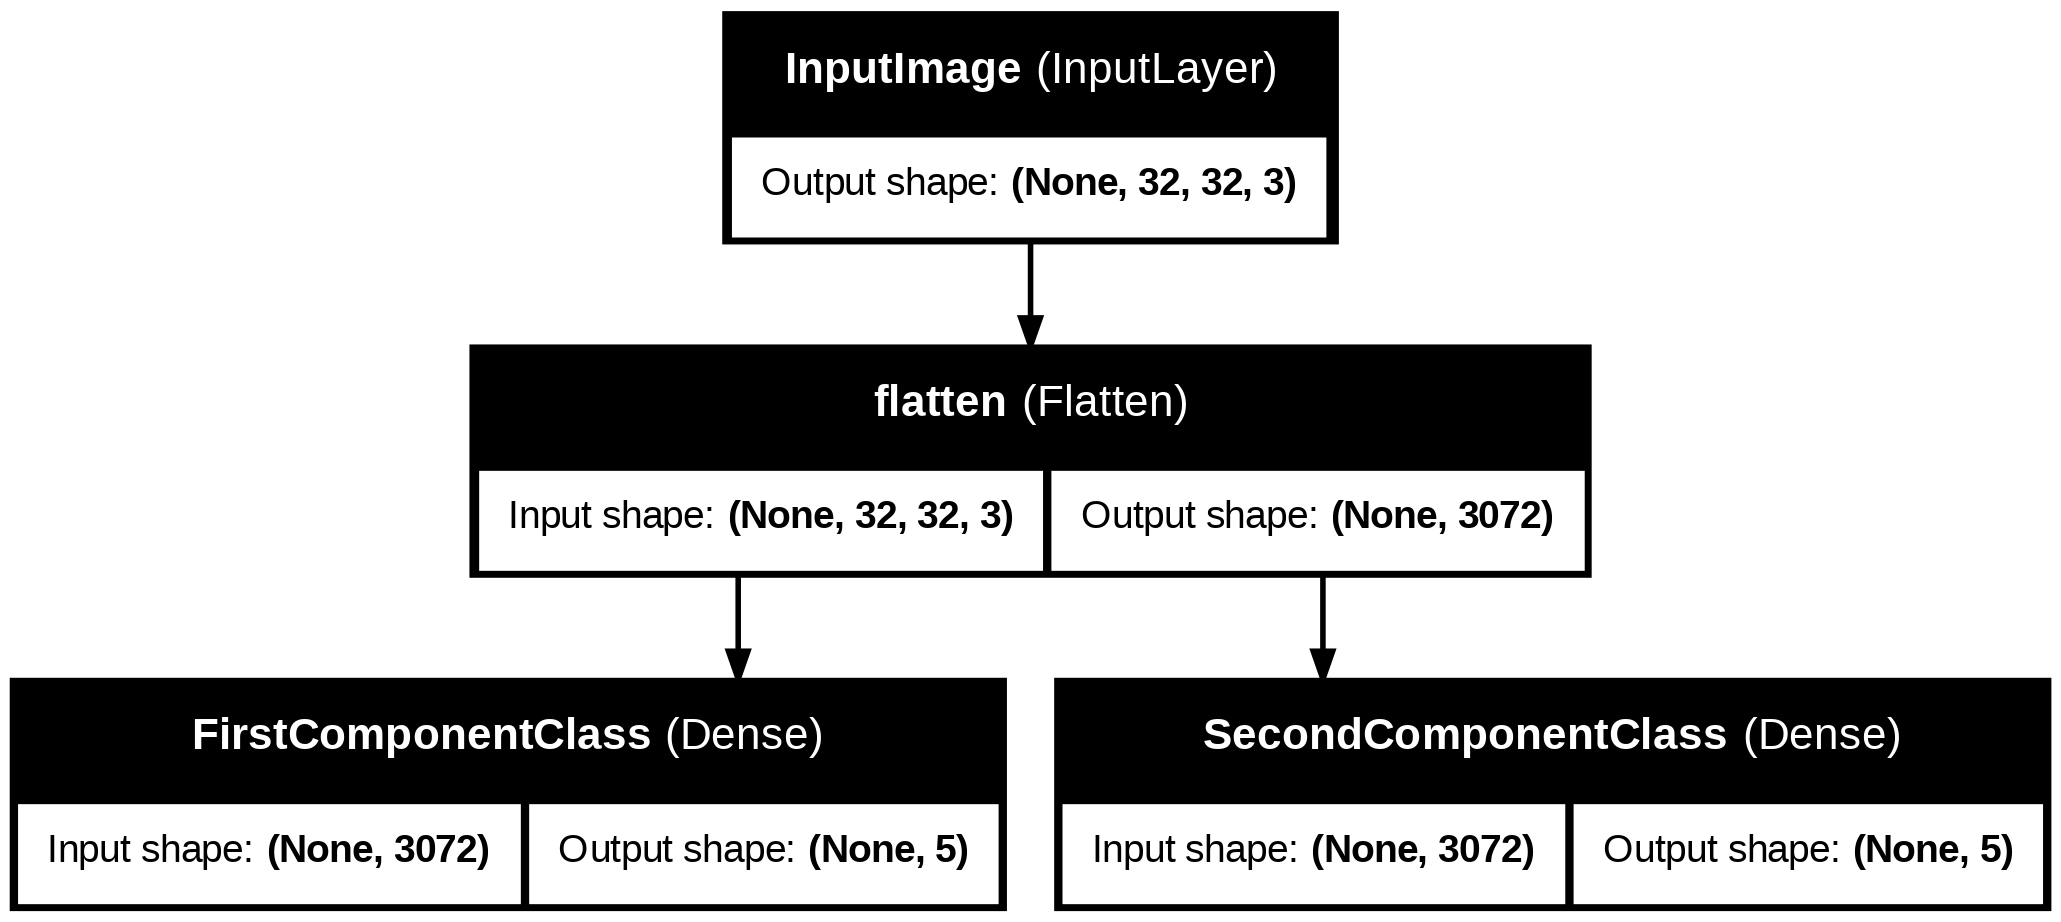

In [19]:
keras.utils.plot_model(model, "model.png", show_shapes = True, show_layer_names = True)

Compilo la rete.

In [20]:
model.compile(
    loss=['categorical_crossentropy', 'categorical_crossentropy'],
    optimizer=keras.optimizers.RMSprop(),
    metrics=['accuracy', 'accuracy'],
)

Addestro la rete.

In [21]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - FirstComponentClass_accuracy: 0.2694 - FirstComponentClass_loss: 1.8096 - SecondComponentClass_accuracy: 0.3029 - SecondComponentClass_loss: 1.7415 - loss: 3.5511 - val_FirstComponentClass_accuracy: 0.2899 - val_FirstComponentClass_loss: 1.7603 - val_SecondComponentClass_accuracy: 0.3908 - val_SecondComponentClass_loss: 1.4481 - val_loss: 3.2083
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - FirstComponentClass_accuracy: 0.3310 - FirstComponentClass_loss: 1.6689 - SecondComponentClass_accuracy: 0.3677 - SecondComponentClass_loss: 1.5769 - loss: 3.2458 - val_FirstComponentClass_accuracy: 0.3048 - val_FirstComponentClass_loss: 1.7041 - val_SecondComponentClass_accuracy: 0.4092 - val_SecondComponentClass_loss: 1.4322 - val_loss: 3.1352
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - FirstComponentClass_accuracy: 0.3457 - FirstComponentClass_loss: 1.6443 - SecondComponentClass_accuracy: 0.3839 - SecondComponentClass_loss: 1

Ora definisco una funzione per la creazione di grafici della storia del training.

dict_keys(['FirstComponentClass_accuracy', 'FirstComponentClass_loss', 'SecondComponentClass_accuracy', 'SecondComponentClass_loss', 'loss', 'val_FirstComponentClass_accuracy', 'val_FirstComponentClass_loss', 'val_SecondComponentClass_accuracy', 'val_SecondComponentClass_loss', 'val_loss'])


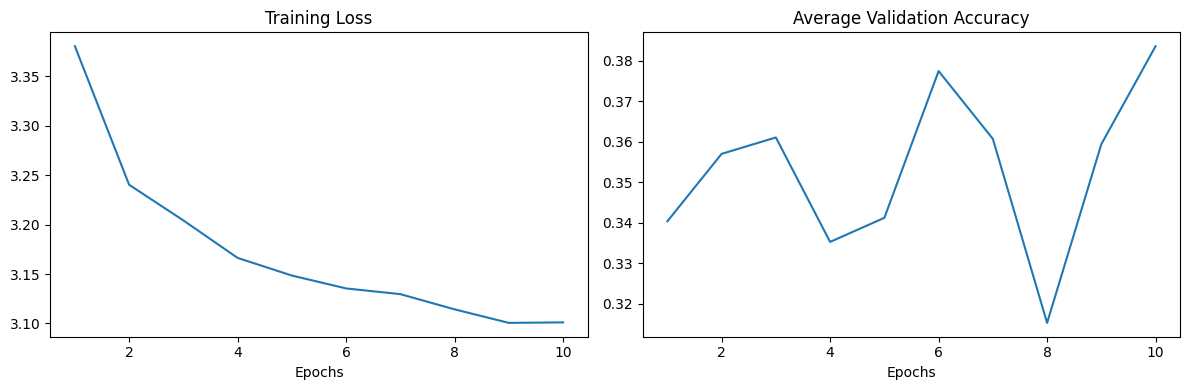

In [22]:
print(history.history.keys())

def plot_training_history(history, num_epochs):

    # Estrai la loss di training e le due accuracy di validation, una per ogni output
    training_loss = history.history['loss']
    val_first_component_class_accuracy = history.history['val_FirstComponentClass_accuracy']
    val_second_component_class_accuracy = history.history['val_SecondComponentClass_accuracy']

    avg_val_accuracy = [(first_accuracy + second_accuracy) / 2 for (first_accuracy, second_accuracy) in zip(val_first_component_class_accuracy, val_second_component_class_accuracy)]

    # Crea un grafico
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, avg_val_accuracy, label='Average Validation Accuracy')
    plt.title('Average Validation Accuracy')
    plt.xlabel('Epochs')

    plt.tight_layout()
    plt.show()

plot_training_history(history, epochs)

Definisco due funzioni per la valutazione finale del modello

In [27]:
def eval_model(model):
  x_test, y_test = next(testgen)
  if isinstance(model, keras.Model):
    guesses = model.predict(x_test)
    correct_guesses_1 = np.argmax(guesses[0], axis=1) == np.argmax(y_test[0], axis=1)
    correct_guesses_2 = np.argmax(guesses[1], axis=1) == np.argmax(y_test[1], axis=1)
  else:
    guesses = model(x_test)
    correct_guesses_1 = guesses[:,0] == np.argmax(y_test[0], axis=1)
    correct_guesses_2 = guesses[:,1] == np.argmax(y_test[1], axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

def multiple_eval_model(model, repeat_eval = 10):
  eval_results = []
  for i in range(repeat_eval):
    eval_results.append(eval_model(model))
  print("mean accuracy = ", np.mean(eval_results))
  print("standard deviation = ", np.std(eval_results))

Valuto la rete e il modello casuale e confronto le loro prestazioni.
Si può facilmente dimostrare che la media delle accuratezze
calcolata utilizzando la funzione "multiple_eval_model" è un numero
appartenente all'intervallo [0,1]

In [28]:
print('Valutazione modello casuale')
multiple_eval_model(random_model)

print('Valutazione rete neurale')
multiple_eval_model(model)

Valutazione modello casuale
mean accuracy =  0.200265
standard deviation =  0.0022026177607565025
Valutazione rete neurale
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
mean accuracy =  0.388745
standard deviation =  0.002767801474094569
